In [1]:
#from sympy import Dummy, lambdify
from numpy import array, hstack, zeros, linspace, pi, ones
from numpy.linalg import solve
from scipy.integrate import odeint
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
import pdb

Shit to try

- Plot M_max and M_min on a graph, as function of \beta^2/\kappa \mu_M and color wrt behaviour


### Valores de Fórmulas (Teorema 3)

$$
    \mathcal{N} = \frac{\alpha \nu}{\mu_M(\nu + \mu_L)}
$$

#### Limit behaviour of Mosquito Population

If $$ \mathcal{N}^{-1} \geq \left[\max_{t\in[0,\tau)} \left(\frac{K_w}{K_p + K_w}(V_{per}(t))\right) + \max_{t\in[0,\tau)} \left(\frac{K_p}{K_p + K_w}(V_{per}(t))\right)\right]$$ then $\lim_{t \to +\infty} X(t) = 0$ for all initial conditions.

If $$ \mathcal{N}^{-1} < \left[\min_{t\in[0,\tau)} \left(\frac{K_w}{K_p + K_w}(V_{per}(t))\right) + \min_{t\in[0,\tau)} \left(\frac{K_p}{K_p + K_w}(V_{per}(t))\right)\right]$$ then there exists a periodic solution which attracts all initial conditions.

#### Limit Behaviour of Disease

If $$\frac{\beta_{hv}\beta_{vh} \max_{t \in [0,\tau)} M_{per}(t)}{\kappa \mu_M} \leq 1,$$
            then $\lim_{t \to +\infty} Y(t) = 0$ for all initial conditions.

If $$\frac{\beta_{hv}\beta_{vh} \min_{t \in [0,\tau)} M_{per}(t)}{\kappa \mu_M} > 1,$$
            then there exists a periodic solution which attracts all initial condition.

In [3]:
class Malaria_System:
    def __init__(self,pr = dict):
        #Valor dos Parametros
        self.beta_vh = pr['beta_vh'] # 0 - 1 per mosquito #
        self.kappa = pr['kappa'] # 1/11 dimensionless
        self.beta_hv = pr['beta_hv'] # Per Mosquito
        self.mu_M = pr['mu_M'] # 0.16 - 0.23 per day
        self.nu = pr['nu'] #1/15.6 +- 2.86 per day
        self.alpha = pr['alpha'] # 83 +- 48 larvae/per female mosquito
        self.mu_L = pr['mu_L'] #0.62 - 0.99 per day - Larvae mortality on ponds without fish
        self.mu_p = pr['mu_p']

        #Parametros da Vegetação

        self.r = pr['r'] # 0.5 Por Mês 
        self.gamma = pr['gamma'] # Proporção de vegetação retirada na limpeza
        self.tau = pr['tau'] # 30-60 dias
        self.H = pr['H'] # Pop. realizando Limpeza - <5%

        #Valor das Carrying Capacities Maximas
        self.K_w_max = pr['K_w_max']
        self.K_p_max = pr['K_p_max']
        self.R_0 = self.beta_hv*self.beta_vh/(self.mu_M*self.kappa)
        
    
    #Carrying capacities em função da vegetação:

    def K_w(self, v):
        #K_w is sigmoid
        #Defining Parameters 
        L = self.K_w_max # Maximum carrying capacity
        k = 5 #Steepness
        x_0 = 0.5 #Sigmoid midpoint
    
        return L/(1 + np.exp(-k*(v - x_0)))
    
    
    def K_p(self, v):
        #K_p is affine
        #Defining Parameters
        K_0 = 0 # Minimum carrying capacity
        L = self.K_p_max # maximum carrying capacity
    
        return K_0 + (L - K_0)*v
    
    
    
    def _right_hand_side_v(self, x , t):
        """Returns the derivatives of the states.

        Parameters
        ----------
        x : ndarray, shape(7,1)
        The current state vector.
        t : float
        The current time.
        args : ndarray
        The constants.

        Returns
        -------
        dx : ndarray, shape(7,1)
        The derivative of the state.
    
        """

        S = x[0]
        I = x[1]
        M_S = x[2]
        M_I = x[3]
        L_p = x[4]
        L_w = x[5]
        V = x[6]
    
        S_dot = - self.beta_vh * S * M_I + self.kappa * I
        I_dot = self.beta_vh * S * M_I - self.kappa * I
        M_I_dot = self.beta_hv * I * M_S - self.mu_M * M_I
        M_S_dot = self.kappa * (L_p + L_w) - self.beta_hv * I * M_S - self.mu_M * M_S
        L_p_dot = self.alpha * (self.K_p(V)/(self.K_p(V) + self.K_w(V))) * (M_I + M_S) * (1 - L_p/self.K_p(V)) - (self.nu + self.mu_L + self.mu_p*(1 - V))*L_p
        L_w_dot = self.alpha * (self.K_w(V)/(self.K_p(V) + self.K_w(V))) * (M_I + M_S) * (1 - L_w/self.K_w(V)) - (self.nu + self.mu_L)*L_w
        V_dot = self.r*(1 - V)
    
        dx = np.array([S_dot,I_dot,M_S_dot,M_I_dot,L_p_dot,L_w_dot,V_dot])
    
        return dx

    def _jump_right_hand_side(self, x):
        """
        Returns the behaviour of the system on points of discontinuities.
    
        Parameters
        ----------
        x: ndarray, shape (7,1)
        current state vector
    
        Returns
        ----------
        dx: ndarray, shape(7,1)
        Delta between values before and after point of discontinuity
        """
        S = x[0]
        I = x[1]
        M_S = x[2]
        M_I = x[3]
        L_p = x[4]
        L_w = x[5]     
        V = x[6]
    
        S_dot = 0
        I_dot = 0
        M_I_dot = 0
        M_S_dot = 0
        L_p_dot = 0
        L_w_dot = 0
        V_dot = -self.gamma*V
    
        dx = np.array([S_dot,I_dot,M_S_dot,M_I_dot,L_p_dot,L_w_dot,V_dot])
    
        return dx
    
    def jump_odeint(self, x_initial,days_range, step):
        """
        Returns the integrated system.
        
        Parameters
        ----------
        RHS :  Right-hand side function.
    
        x_initial: vector, initial state of the system.
    
        time_vector: linspace, time over which will be integrated.
    
        jump_RHS: Discrete Delta at discontinuities.

        Returns
        -------
        y(t) : for each t in time_vector, the state y(t) of the system.
    
        """
    
        self.time_vector =  linspace(0, days_range, int(days_range/step))
        periods = []
        for i in range(0,int(np.ceil(300/self.tau))):
            periods.append((i+1)*int(self.tau/step)) 

        continuous_intervals = np.split(self.time_vector,periods) #split time vector between times in jump_vector
    
        y = np.array([x_initial])
        for interval in continuous_intervals:
            if len(interval) > 0:
                y = np.append(y,odeint(self._right_hand_side_v ,y[-1],interval),axis = 0)
                y = np.append(y,np.array([y[-1] + self._jump_right_hand_side(y[-1])]),axis = 0)
        
        self.y = y[:self.time_vector.shape[0]]
        
    
        
    def Veg(self, t):
        return 1 - (self.gamma * np.exp(-self.r* (t % self.tau)))/(1 - (1 - self.gamma)*np.exp(-self.r*self.tau))
    
    def Mosquito_threshold(self):
        t = linspace(0, self.tau, self.tau*10000)
        
        thres = ((self.nu + self.mu_L)*self.mu_M)/(self.alpha*self.nu)
        maxx =   np.max(self.K_w(self.Veg(t))/(self.K_p(self.Veg(t))+self.K_w(self.Veg(t)))) + np.max(self.K_p(self.Veg(t))/(self.K_p(self.Veg(t))+self.K_w(self.Veg(t))))
        minn = np.min(self.K_w(self.Veg(t))/(self.K_p(self.Veg(t))+self.K_w(self.Veg(t)))) + np.min(self.K_p(self.Veg(t))/(self.K_p(self.Veg(t))+self.K_w(self.Veg(t))))
        print("Threshold = ",thres, "\n \n Upper Bound = ",maxx, "\n\n Lower Bound =", minn)
        
        if thres >= maxx: print("Limit to zero");   return False
        if thres < minn: print("Limit to periodic solution");  return True
        if minn <= thres and thres < maxx: print("Inconclusive Result"); return None
        
        
    def Disease_threshold(self):
        bigM = self.y.T[2,:-self.tau] + self.y.T[3,:-self.tau]
        print("min = ", self.beta_hv*self.beta_vh*np.min(bigM)/(self.kappa*self.mu_M),"\n")
        print("max = ", self.beta_hv*self.beta_vh*np.max(bigM)/(self.kappa*self.mu_M),"\n")
        if self.beta_hv*self.beta_vh*np.min(bigM)/(self.kappa*self.mu_M) > 1:
            print("periodic solution")
        if self.beta_hv*self.beta_vh*np.max(bigM)/(self.kappa*self.mu_M) <= 1:
            print("Solution converges to zero")
        return
    
    def Plot(self):
        
        t = self.time_vector
        fig, axs = plt.subplots(4,2, figsize=(20, 20))
        
        axs[0, 0].plot(t, self.y[:,0])
        axs[0, 0].set_xlabel('time (days)')
        axs[0, 0].set_ylabel('S(t)')
        
        axs[0, 1].plot(t, self.y[:,1])
        axs[0, 1].set_xlabel('time (days)')
        axs[0, 1].set_ylabel('I(t)')
        
        axs[1, 0].plot(t, self.y[:,2])
        axs[1, 0].set_xlabel('time (days)')
        axs[1, 0].set_ylabel('M_S(t)')
        
        axs[1, 1].plot(t, self.y[:,3])
        axs[1, 1].set_xlabel('time (days)')
        axs[1, 1].set_ylabel('M_I(t)')
        
        axs[2, 0].plot(t, self.y[:,4])
        axs[2, 0].set_xlabel('time (days)')
        axs[2, 0].set_ylabel('L_f(t)')
        
        axs[2, 1].plot(t, self.y[:,5])
        axs[2, 1].set_xlabel('time (days)')
        axs[2, 1].set_ylabel('L_c(t)')
        
        axs[3, 0].plot(t, self.y[:,6])
        axs[3, 0].set_xlabel('time (days)')
        axs[3, 0].set_ylabel('V(t)')
        
        plt.show()
        return

In [4]:
prms_0 = dict(#Valor dos Parametros
beta_vh = 0.2, # 0 - 1 per mosquito #
kappa = 1/11, # 1/11 dimensionless
beta_hv = 0.2, # Per Mosquito
mu_M = 0.16, # 0.16 - 0.23 per day
nu = 1/15.6, # 1/15.6 +- 2.86 per day
alpha = 83,# 83 +- 48 larvae/per female mosquito
mu_L = 0.62, #0.62 - 0.99 per day - Larvae mortality on ponds without fish
mu_p = 0.31,

#Parametros da Vegetação

r = 0.5/30, # 0.5 Por Mês 
gamma = 0.65, # Proporção de vegetação retirada na limpeza
tau = 30, # 30-60 dias
H = 0.05, # Pop. realizando Limpeza - <5%

#Valor das Carrying Capacities Maximas
K_w_max = 0.4,
K_p_max = 4)

In [5]:
prms_1 = dict(#Valor dos Parametros
beta_vh = 0.2, # 0 - 1 per mosquito #
kappa = 1/11, # 1/11 dimensionless
beta_hv = 0.2, # Per Mosquito
mu_p = 0.31,

mu_M = 0.70, # 0.16 - 0.23 per day
mu_L = 0.99, #0.62 - 0.99 per day - Larvae mortality on ponds without fish

nu = 1/(15.6 + 2.86), # 1/15.6 +- 2.86 per day


alpha = 83 - 70, # 83 +- 48 larvae/per female mosquito


#Parametros da Vegetação

r = 0.5/30, # 0.5 Por Mês 
gamma = 0.65, # Proporção de vegetação retirada na limpeza
tau = 10,  # 30-60 dias
H = 0.05, # Pop. realizando Limpeza - <5%

#Valor das Carrying Capacities Maximas
K_w_max = 0.4,
K_p_max = 4)

In [6]:
prms_2 = dict(#Valor dos Parametros
beta_vh = 0.1, # 0 - 1 per mosquito #
kappa = 1/11, # 1/11 dimensionless
beta_hv = 0.1, # Per Mosquito
mu_M = 0.16, # 0.16 - 0.23 per day
nu = 1/15.6, # 1/15.6 +- 2.86 per day
alpha = 83, # 83 +- 48 larvae/per female mosquito
mu_L = 0.62, #0.62 - 0.99 per day - Larvae mortality on ponds without fish
mu_p = 0.31,

#Parametros da Vegetação

r = 0.5/30, # 0.5 Por Mês 
gamma = 0.65, # Proporção de vegetação retirada na limpeza
tau = 30, # 30-60 dias
H = 0.05, # Pop. realizando Limpeza - <5%

#Valor das Carrying Capacities Maximas
K_w_max = 0.4,
K_p_max = 4)

In [7]:
prms_3 = dict(#Valor dos Parametros
beta_vh = 0.2, # 0 - 1 per mosquito #
kappa = 1/11, # 1/11 dimensionless
beta_hv = 0.2, # Per Mosquito
mu_M = 0.16, # 0.16 - 0.23 per day
nu = 1/15.6, # 1/15.6 +- 2.86 per day
alpha = 83, # 83 +- 48 larvae/per female mosquito
mu_L = 0.62, #0.62 - 0.99 per day - Larvae mortality on ponds without fish
mu_p = 0.31,

#Parametros da Vegetação

r = 0.5/30, # 0.5 Por Mês 
gamma = 0.65, # Proporção de vegetação retirada na limpeza
tau = 5, # 30-60 dias
H = 0.10, # Pop. realizando Limpeza - <5%

#Valor das Carrying Capacities Maximas
K_w_max = 0.4,
K_p_max = 4)

## Cenário 0:

### Parâmetros

Parâmetros Normais, ie: sem nenhum tipo de comportamento a destacar

In [8]:
system = Malaria_System(prms_0)

x0 = np.array([0.9,0.1,0.5,0,2,0.2,0.7])

system.jump_odeint(x0,300,0.01)

In [9]:
system.Mosquito_threshold()

Threshold =  0.020572530120481925 
 
 Upper Bound =  1.00913799022 

 Lower Bound = 0.990862009784
Limit to periodic solution


True

In [11]:
system.Disease_threshold()

min =  1.3750000000000002 

max =  5.371267812785648 

periodic solution


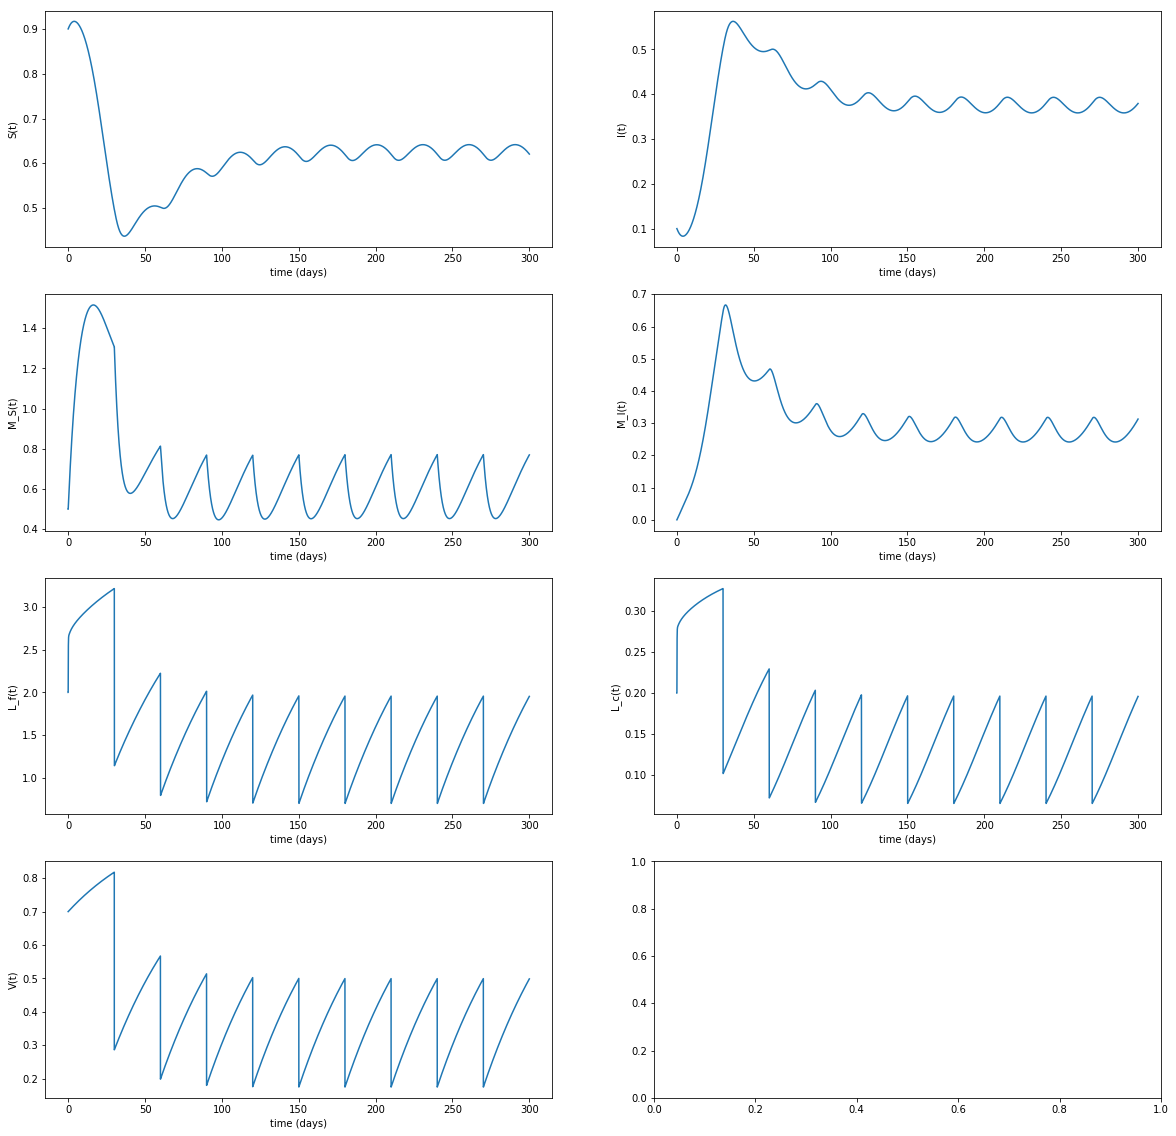

In [12]:
system.Plot()

## Cenário 1

Mosquito tendendo a zero

In [5]:
system = Malaria_System(prms_1)

x0 = np.array([0.9,0.1,0.5,0,2,0.2,0.7])

system.jump_odeint(x0,300,0.01)

NameError: name 'Malaria_System' is not defined

In [4]:
system.Mosquito_threshold()

NameError: name 'system' is not defined

In [ ]:
%debug

In [33]:
system.Disease_threshold()

min =  0.01144056669960731 

max =  0.3142857142857144 

Solution converges to zero


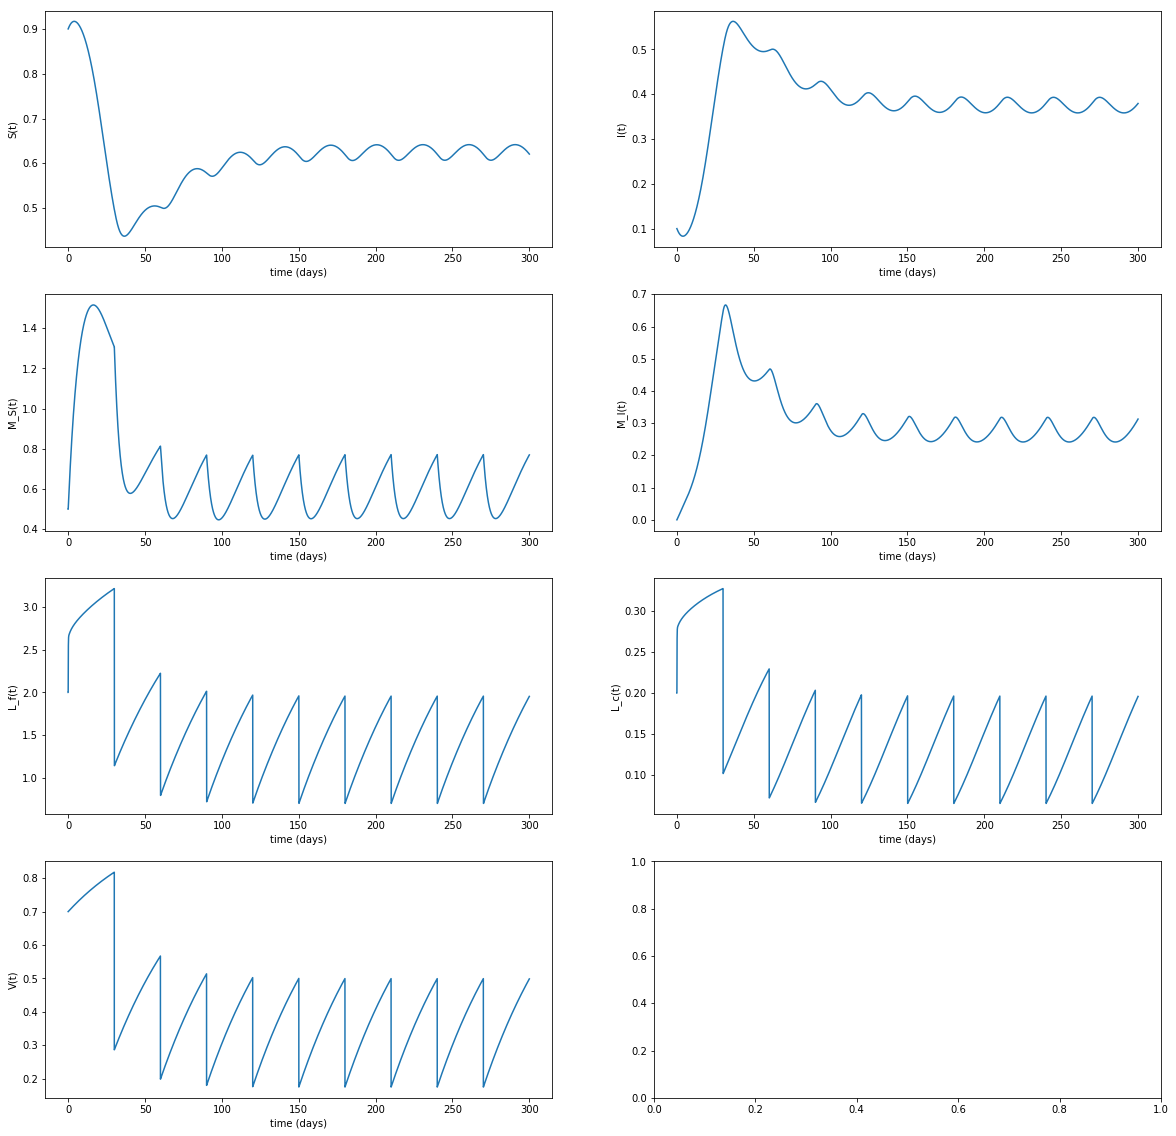

In [23]:
system.Plot()

In [31]:
x0 = np.array([0.9,0.1,0.5,0,9.588,9.588]) #Initial conditions

t = linspace(0, 300, 30000)                 # Time vector
y = odeint(right_hand_side, x0, t)         # Actual integration

In [32]:
Mosquito_threshold()

In [33]:
mu_M*(nu + mu_L)/(alpha*nu)

1.0379061538461536

In [13]:
np.max((K_w(V(t))/(K_p(V(t))+K_w(V(t))))) + np.max((K_p(V(t))/(K_p(V(t))+K_w(V(t)))))

1.0406781647367296

In [14]:
Disease_threshold()

Solution converges to zero


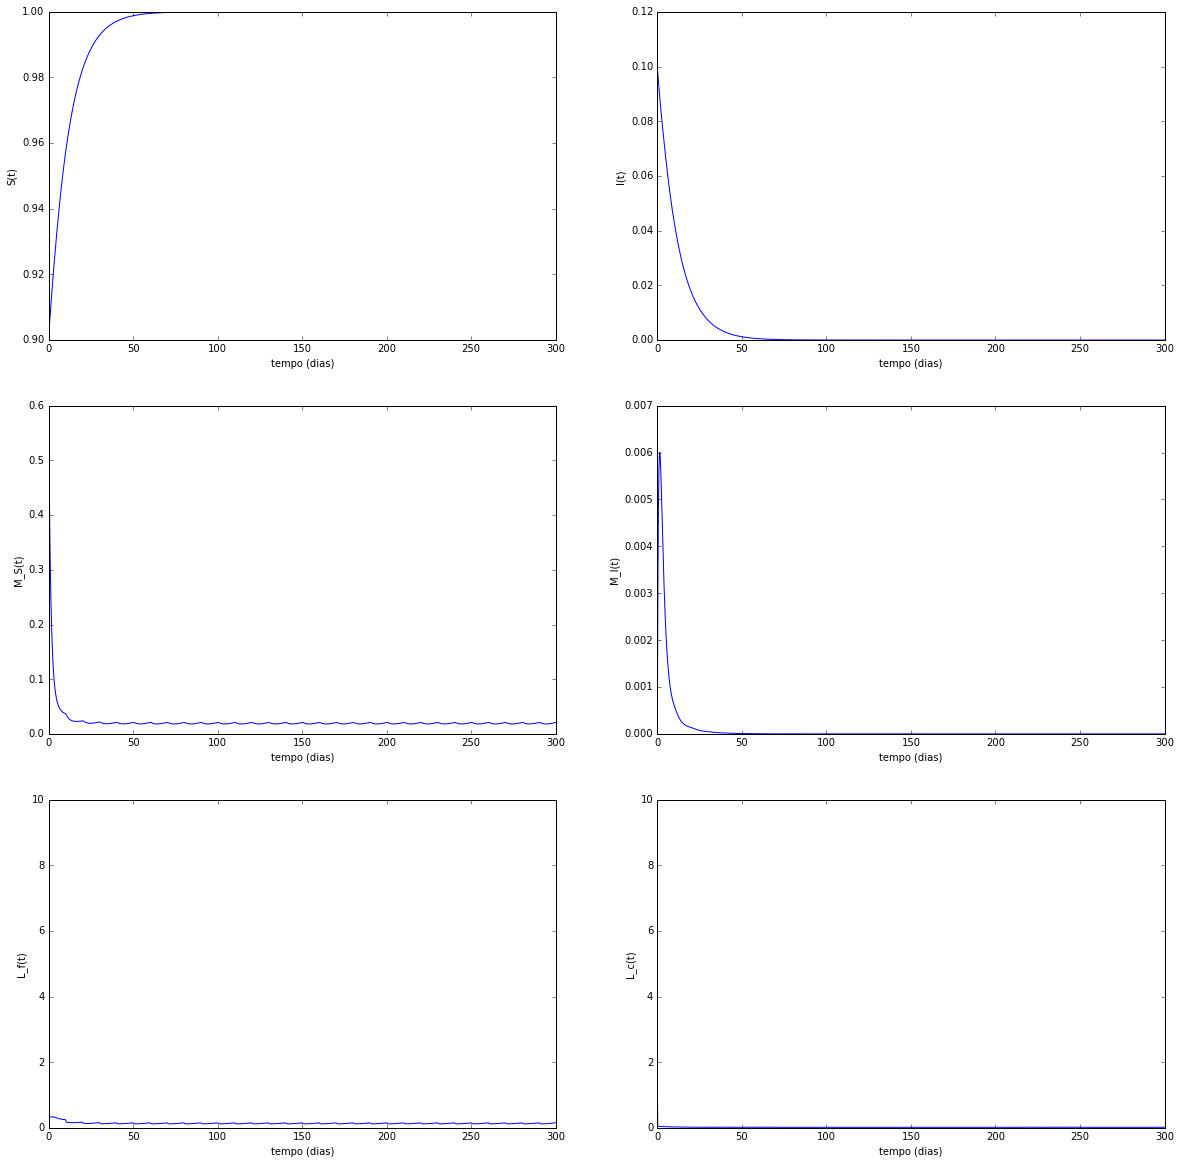

In [19]:

fig, axs = plt.subplots(4,2, figsize=(20, 20))

axs[0, 0].plot(t, y[:,0])
axs[0, 0].set_xlabel('tempo (dias)')
axs[0, 0].set_ylabel('S(t)')

axs[0, 1].plot(t, y[:,1])
axs[0, 1].set_xlabel('tempo (dias)')
axs[0, 1].set_ylabel('I(t)')



axs[1, 0].plot(t, y[:,2])
axs[1, 0].set_xlabel('tempo (dias)')
axs[1, 0].set_ylabel('M_S(t)')


axs[1, 1].plot(t, y[:,3])
axs[1, 1].set_xlabel('tempo (dias)')
axs[1, 1].set_ylabel('M_I(t)')


axs[2, 0].plot(t, y[:,4])
axs[2, 0].set_xlabel('tempo (dias)')
axs[2, 0].set_ylabel('L_f(t)')

axs[2, 1].plot(t, y[:,5])
axs[2, 1].set_xlabel('tempo (dias)')
axs[2, 1].set_ylabel('L_c(t)')

axs[0, 3].plot(t, V(t))
axs[0, 3].set_xlabel('tempo (dias)')
axs[0, 3].set_ylabel('V(t)')


plt.show()

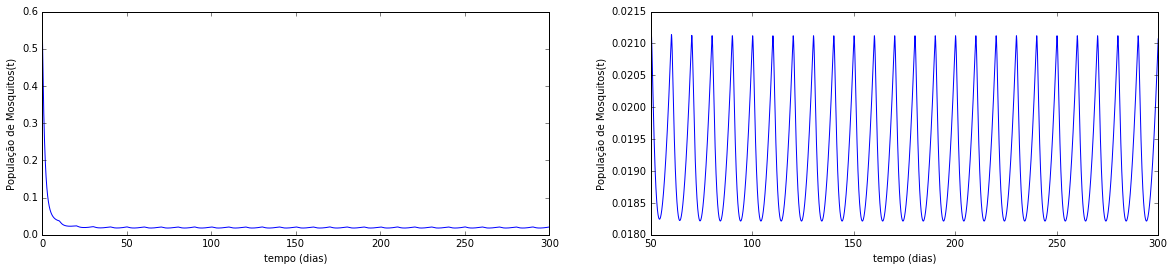

In [124]:
fig, axs = plt.subplots(1,2, figsize=(20, 4))

axs[0].plot(t, y[:,2]+y[:,3])
axs[0].set_xlabel('tempo (dias)')
axs[0].set_ylabel('População de Mosquitos(t)')

axs[1].plot( t[5000:], y[5000:,2]+y[5000:,3])
axs[1].set_xlabel('tempo (dias)')
axs[1].set_ylabel('População de Mosquitos(t)')

O teste do teorema é inconclusivo. Podemos observar nas simulações que a população total de mosquitos tende para um resultado periódico, porém próximo de zero

## Cenário 1.1

In [57]:
#Valor dos Parametros
beta_vh = 0.2 # 0 - 1 per mosquito #
kappa = 1/11 # 1/11 dimensionless
beta_hv = beta_vh # Per Mosquito
mu_p = 0.31

mu_M = 0.70 # 0.16 - 0.23 per day
mu_L = 0.99 #0.62 - 0.99 per day - Larvae mortality on ponds without fish

nu = 1/(15.6 + 2.86) # 1/15.6 +- 2.86 per day


alpha = 83 - 74 # 83 +- 48 larvae/per female mosquito


#Parametros da Vegetação

r = 0.5/30 # 0.5 Por Mês 
gamma = 0.65 # Proporção de vegetação retirada na limpeza
tau = 10 # 30-60 dias
H = 0.05# Pop. realizando Limpeza - <5%

#Valor das Carrying Capacities Maximas
K_w_max = 0.4
K_p_max = 4


x0 = np.array([0.9,0.1,0.5,0,9.588,9.588]) #Initial conditions

t = linspace(0, 300, 30000)                 # Time vector
y = odeint(right_hand_side, x0, t)         # Actual integration

In [167]:
mu_M*(nu + mu_L)/(alpha*nu)

1.4991977777777774

In [162]:
np.max((K_w(V(t))/(K_p(V(t))+K_w(V(t))))) + np.max((K_p(V(t))/(K_p(V(t))+K_w(V(t)))))

1.0406781647367296

In [168]:
Mosquito_threshold()

Limit to zero


In [129]:
Disease_threshold()

Solution converges to zero


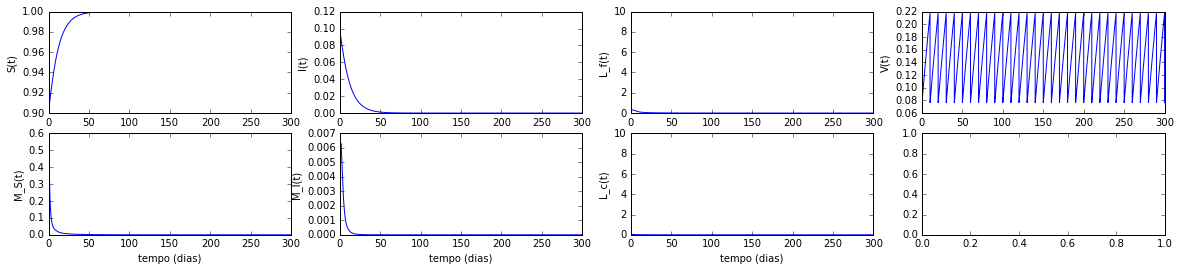

In [169]:

fig, axs = plt.subplots(2,4, figsize=(20, 4))

axs[0, 0].plot(t, y[:,0])
axs[0, 0].set_xlabel('tempo (dias)')
axs[0, 0].set_ylabel('S(t)')

axs[0, 1].plot(t, y[:,1])
axs[0, 1].set_xlabel('tempo (dias)')
axs[0, 1].set_ylabel('I(t)')



axs[1, 0].plot(t, y[:,2])
axs[1, 0].set_xlabel('tempo (dias)')
axs[1, 0].set_ylabel('M_S(t)')


axs[1, 1].plot(t, y[:,3])
axs[1, 1].set_xlabel('tempo (dias)')
axs[1, 1].set_ylabel('M_I(t)')


axs[0, 2].plot(t, y[:,4])
axs[0, 2].set_xlabel('tempo (dias)')
axs[0, 2].set_ylabel('L_f(t)')

axs[1, 2].plot(t, y[:,5])
axs[1, 2].set_xlabel('tempo (dias)')
axs[1, 2].set_ylabel('L_c(t)')

axs[0, 3].plot(t, V(t))
axs[0, 3].set_xlabel('tempo (dias)')
axs[0, 3].set_ylabel('V(t)')


plt.show()

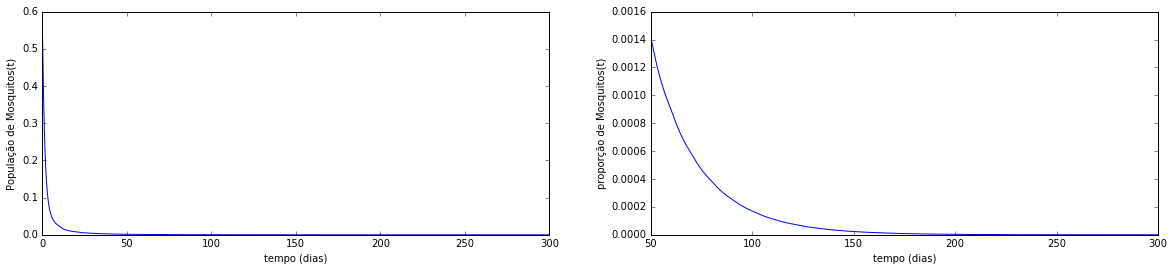

In [170]:
fig, axs = plt.subplots(1,2, figsize=(20, 4))

axs[0].plot(t, y[:,2] + y[:,3])
axs[0].set_xlabel('tempo (dias)')
axs[0].set_ylabel('População de Mosquitos(t)')

axs[1].plot( t[5000:], y[5000:,2]+y[5000:,3])
axs[1].set_xlabel('tempo (dias)')
axs[1].set_ylabel('proporção de Mosquitos(t)')

In [ ]:
O teste do teorema implica em convergência para zero da população de mosquitos. Podemos observar nas simulações tal comportamento.

## Cenário 2

In [50]:
# Integração
x0 = np.array([0.9,0.1,0.5,0,2,0.2]) #Initial conditions

t = linspace(0, 300, 30000)                 # Time vector
y = odeint(right_hand_side, x0, t)         # Actual integration

In [55]:
1/15.6

0.06410256410256411

In [179]:
Mosquito_threshold()

Limit to periodic solution


In [ ]:
# Threshold Value



In [180]:
Disease_threshold()

Solution converges to zero


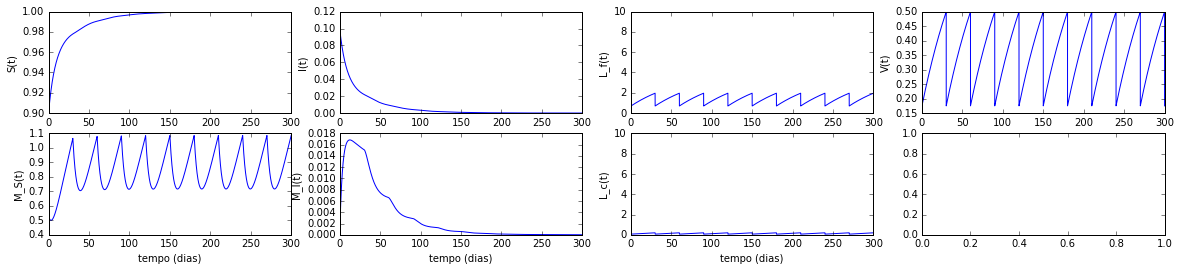

In [181]:

fig, axs = plt.subplots(2,4, figsize=(20, 4))

axs[0, 0].plot(t, y[:,0])
axs[0, 0].set_xlabel('tempo (dias)')
axs[0, 0].set_ylabel('S(t)')

axs[0, 1].plot(t, y[:,1])
axs[0, 1].set_xlabel('tempo (dias)')
axs[0, 1].set_ylabel('I(t)')



axs[1, 0].plot(t, y[:,2])
axs[1, 0].set_xlabel('tempo (dias)')
axs[1, 0].set_ylabel('M_S(t)')


axs[1, 1].plot(t, y[:,3])
axs[1, 1].set_xlabel('tempo (dias)')
axs[1, 1].set_ylabel('M_I(t)')


axs[0, 2].plot(t, y[:,4])
axs[0, 2].set_xlabel('tempo (dias)')
axs[0, 2].set_ylabel('L_f(t)')

axs[1, 2].plot(t, y[:,5])
axs[1, 2].set_xlabel('tempo (dias)')
axs[1, 2].set_ylabel('L_c(t)')

axs[0, 3].plot(t, V(t))
axs[0, 3].set_xlabel('tempo (dias)')
axs[0, 3].set_ylabel('V(t)')


plt.show()

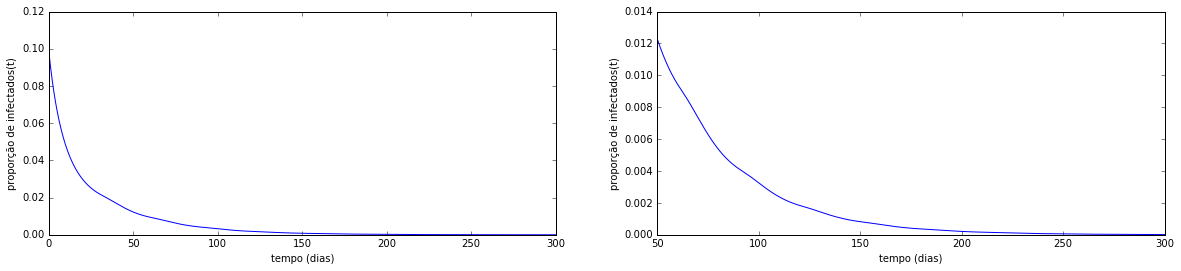

In [182]:
fig, axs = plt.subplots(1,2, figsize=(20, 4))

axs[0].plot(t, y[:,1])
axs[0].set_xlabel('tempo (dias)')
axs[0].set_ylabel('proporção de infectados(t)')

axs[1].plot( t[5000:], y[5000:,1])
axs[1].set_xlabel('tempo (dias)')
axs[1].set_ylabel('proporção de infectados(t)')

O teste do teorema implica em população de mosquito periódica, mas doença tendendo a zero. Podemos observar esse comportamento nas simulações.

## Cenário 3

In [22]:
x0 = np.array([0.9,0.1,0.5,0,9.588,9.588]) #Initial conditions

t = linspace(0, 300, 30000)                 # Time vector
y = odeint(right_hand_side, x0, t)         # Actual integration

In [23]:
Mosquito_threshold()

Limit to periodic solution


In [24]:
Disease_threshold()

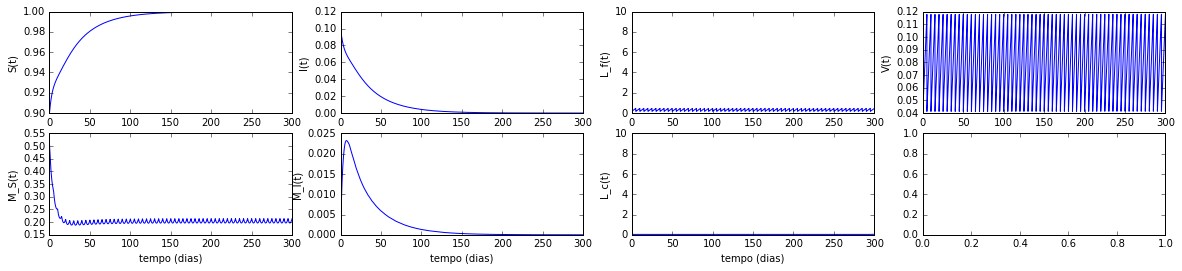

In [25]:

fig, axs = plt.subplots(2,4, figsize=(20, 4))

axs[0, 0].plot(t, y[:,0])
axs[0, 0].set_xlabel('tempo (dias)')
axs[0, 0].set_ylabel('S(t)')

axs[0, 1].plot(t, y[:,1])
axs[0, 1].set_xlabel('tempo (dias)')
axs[0, 1].set_ylabel('I(t)')



axs[1, 0].plot(t, y[:,2])
axs[1, 0].set_xlabel('tempo (dias)')
axs[1, 0].set_ylabel('M_S(t)')


axs[1, 1].plot(t, y[:,3])
axs[1, 1].set_xlabel('tempo (dias)')
axs[1, 1].set_ylabel('M_I(t)')


axs[0, 2].plot(t, y[:,4])
axs[0, 2].set_xlabel('tempo (dias)')
axs[0, 2].set_ylabel('L_f(t)')

axs[1, 2].plot(t, y[:,5])
axs[1, 2].set_xlabel('tempo (dias)')
axs[1, 2].set_ylabel('L_c(t)')

axs[0, 3].plot(t, V(t))
axs[0, 3].set_xlabel('tempo (dias)')
axs[0, 3].set_ylabel('V(t)')


plt.show()

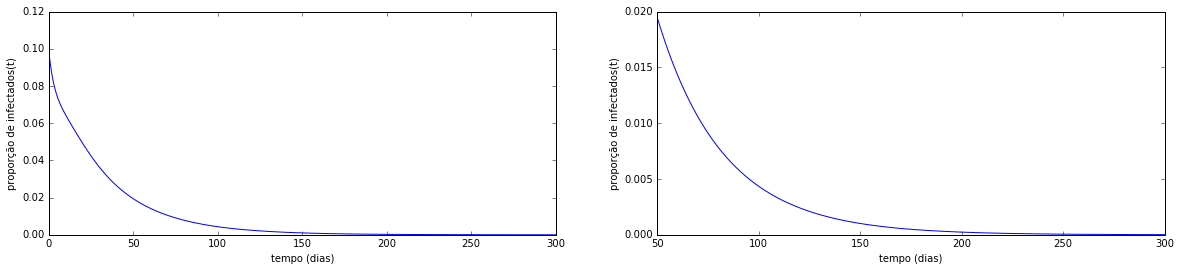

In [138]:
fig, axs = plt.subplots(1,2, figsize=(20, 4))

axs[0].plot(t, y[:,1])
axs[0].set_xlabel('tempo (dias)')
axs[0].set_ylabel('proporção de infectados(t)')

axs[1].plot( t[5000:], y[5000:,1])
axs[1].set_xlabel('tempo (dias)')
axs[1].set_ylabel('proporção de infectados(t)')

Cenário 4

In [36]:
#Valor dos Parametros
beta_vh = 0.2 # 0 - 1 per mosquito #
kappa = 1/11 # 1/11 dimensionless
beta_hv = beta_vh # Per Mosquito
mu_M = 0.16 # 0.16 - 0.23 per day
nu = 1/15.6 # 1/15.6 +- 2.86 per day
alpha = 83 # 83 +- 48 larvae/per female mosquito
mu_L = 0.62 #0.62 - 0.99 per day - Larvae mortality on ponds without fish
mu_p = 0.31

#Parametros da Vegetação

r = 0.5/30 # 0.5 Por Mês 
gamma = 0.65 # Proporção de vegetação retirada na limpeza
tau = 5# 30-60 dias
H = 0.10# Pop. realizando Limpeza - <5%

#Valor das Carrying Capacities Maximas
K_w_max = 0.4
K_p_max = 4

In [37]:
x0 = np.array([0.9,0.1,0.5,0,9.588,9.588]) #Initial conditions

t = linspace(0, 300, 30000)                 # Time vector
y = odeint(right_hand_side, x0, t)         # Actual integration

In [38]:
Mosquito_threshold()

Limit to periodic solution


In [39]:
Disease_threshold()

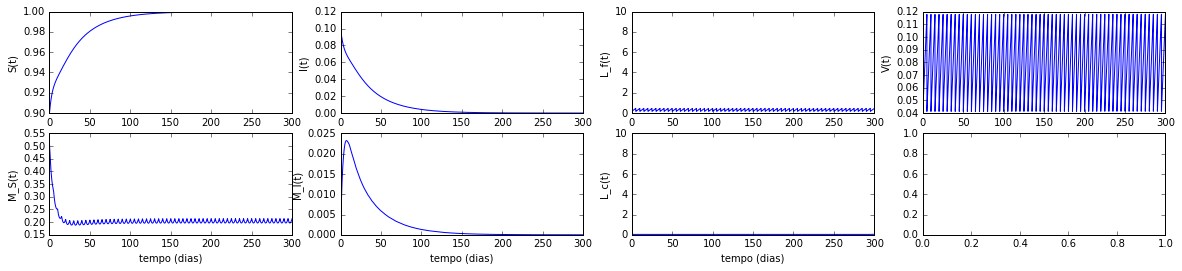

In [40]:

fig, axs = plt.subplots(2,4, figsize=(20, 4))

axs[0, 0].plot(t, y[:,0])
axs[0, 0].set_xlabel('tempo (dias)')
axs[0, 0].set_ylabel('S(t)')

axs[0, 1].plot(t, y[:,1])
axs[0, 1].set_xlabel('tempo (dias)')
axs[0, 1].set_ylabel('I(t)')



axs[1, 0].plot(t, y[:,2])
axs[1, 0].set_xlabel('tempo (dias)')
axs[1, 0].set_ylabel('M_S(t)')


axs[1, 1].plot(t, y[:,3])
axs[1, 1].set_xlabel('tempo (dias)')
axs[1, 1].set_ylabel('M_I(t)')


axs[0, 2].plot(t, y[:,4])
axs[0, 2].set_xlabel('tempo (dias)')
axs[0, 2].set_ylabel('L_f(t)')

axs[1, 2].plot(t, y[:,5])
axs[1, 2].set_xlabel('tempo (dias)')
axs[1, 2].set_ylabel('L_c(t)')

axs[0, 3].plot(t, V(t))
axs[0, 3].set_xlabel('tempo (dias)')
axs[0, 3].set_ylabel('V(t)')


plt.show()

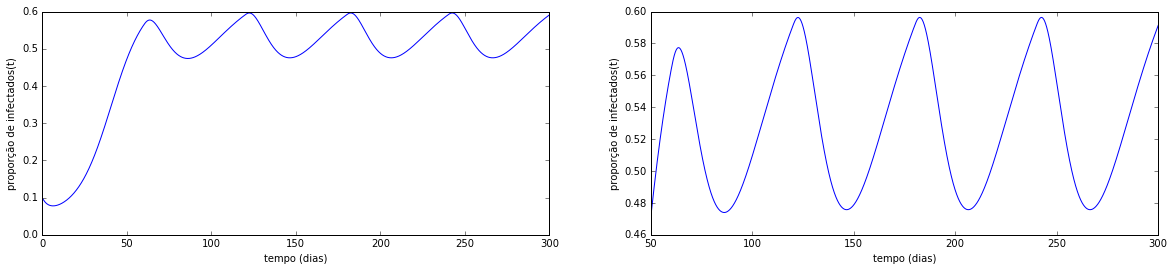

In [115]:
fig, axs = plt.subplots(1,2, figsize=(20, 4))

axs[0].plot(t, y[:,1])
axs[0].set_xlabel('tempo (dias)')
axs[0].set_ylabel('proporção de infectados(t)')

axs[1].plot( t[5000:], y[5000:,1])
axs[1].set_xlabel('tempo (dias)')
axs[1].set_ylabel('proporção de infectados(t)')

In [45]:
Y = np.zeros((6,30000))

In [46]:
Y[0] = y[:,1]

(30000,)

## Simulação para diferentes períodos de limpeza

# Plotting Different Trajectories on the same graph

In [10]:
params = dict(
#Valor dos Parametros
beta_vh = 0.2, # 0 - 1 per mosquito #
kappa = 1/11, # 1/11 dimensionless
beta_hv = 0.2, # Per Mosquito
mu_M = 0.16, # 0.16 - 0.23 per day
nu = 1/15.6,# 1/15.6 +- 2.86 per day
alpha = 83, # 83 +- 48 larvae/per female mosquito
mu_L = 0.62, #0.62 - 0.99 per day - Larvae mortality on ponds without fish
mu_p = 0.31,

#Parametros da Vegetação

r = 0.5/30, # 0.5 Por Mês 
gamma = 0.65, # Proporção de vegetação retirada na limpeza
tau = 30, # 30-60 dias
H = 0.05,# Pop. realizando Limpeza - <5%

step = 0.01,

#Valor das Carrying Capacities Maximas
K_w_max = 0.4,
K_p_max = 4
)    


In [17]:
system = Malaria_System(params)
step = 0.01
num_days = 300

## Varying Cleaning Periodicity

In [34]:
#integrating
taus = [600,60,30,20,15,10,5]
#taus = linspace(0,1,10)
step = 0.01
num_days = 300

In [35]:
Y = []

for tau in taus:
    x_0 = np.array([0.9,0.1,0.5,0,2,0.2,0.7])
    system.tau = tau
    system.jump_odeint(x_0,num_days,step)
    Y.append(system.y)
    


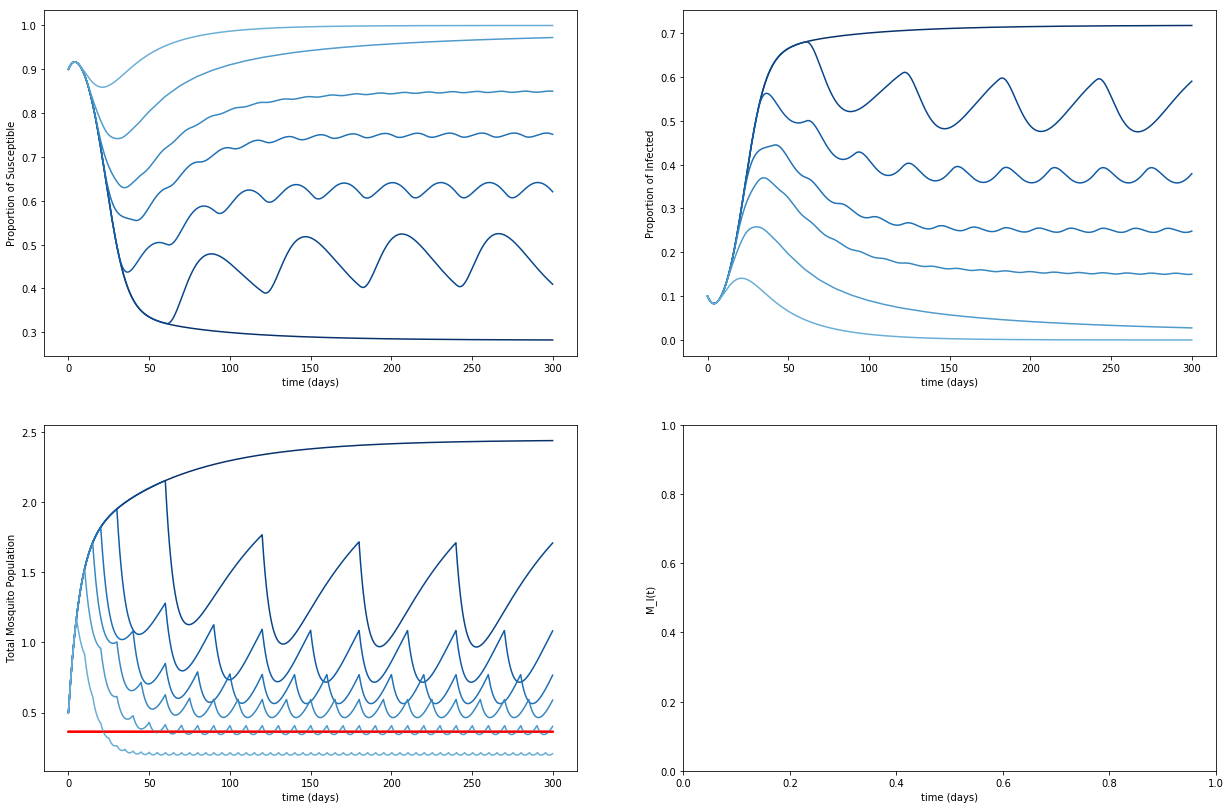

In [42]:
# Plotting

start = 1.0
stop = 0.5
number_of_lines= len(Y)
cm_subsection = linspace(start, stop, number_of_lines) 

colors = [ cm.get_cmap('Blues')(x) for x in cm_subsection ]

fig, axs = plt.subplots(2,2, figsize=(21, 14))

for i,y in enumerate(Y):
    #plt.plot(t,y[:,1],color = colors[i])
    axs[0, 0].plot(t, y[:,0],color = colors[i])
    axs[0, 1].plot(t, y[:,1],color = colors[i])
    axs[1, 0].plot(t, (y[:,2] + y[:,3]),color = colors[i])
    axs[1, 0].plot(system.time_vector, (1/system.R_0)*np.ones(system.time_vector.shape), color = 'red')
    #axs[1, 1].plot(t, y[:,3],color = colors[i])
    #axs[2, 0].plot(t, y[:,4],color = colors[i])
    #axs[2, 1].plot(t, y[:,5],color = colors[i])
    #axs[3, 0].plot(t, y[:,6],color = colors[i])
    #axs[3, 1].axhline(taus[i], color=colors[i])
    
    
axs[0, 0].set_xlabel('time (days)')
axs[0, 0].set_ylabel('Proportion of Susceptible')
axs[0, 1].set_xlabel('time (days)')
axs[0, 1].set_ylabel('Proportion of Infected')
axs[1, 0].set_xlabel('time (days)')
axs[1, 0].set_ylabel('Total Mosquito Population')
axs[1, 1].set_xlabel('time (days)')
axs[1, 1].set_ylabel('M_I(t)')
#axs[2, 0].set_xlabel('time (days)')
#axs[2, 0].set_ylabel('L_f(t)')
#axs[2, 1].set_xlabel('time (days)')
#axs[2, 1].set_ylabel('L_c(t)')
#axs[3, 0].set_xlabel('time (days)')
#axs[3, 0].set_ylabel('V(t)')
#axs[3, 1].set_xlabel('Color for different periods(days)')
#axs[3, 1].set_ylabel('periods')
    
    
    
plt.show()

In [18]:
taus = [60,10,5]

Y = []

for tau in taus:
    x_0 = np.array([0.9,0.1,0.5,0,2,0.2,0.7])
    system.tau = tau
    system.jump_odeint(x_0,num_days,step)
    Y.append(system.y)
    


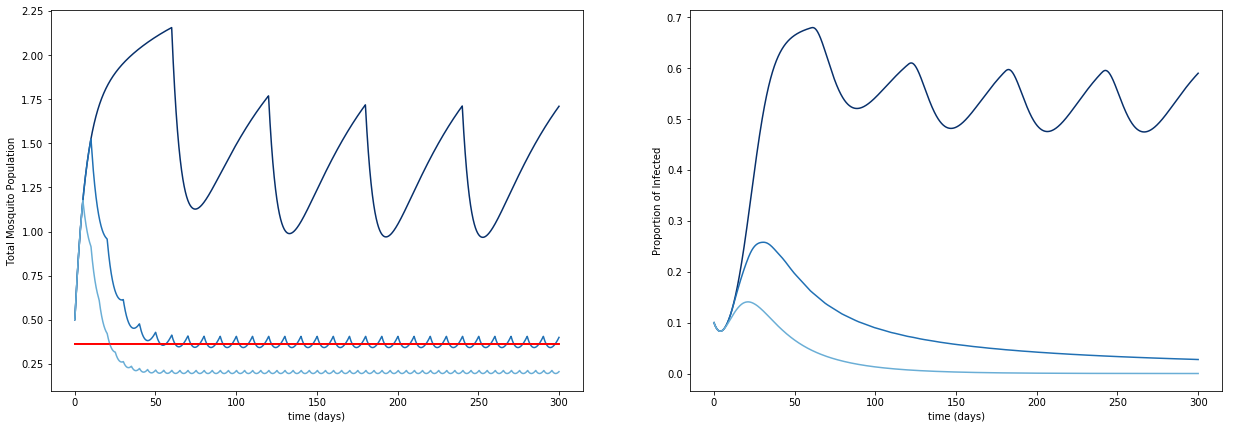

In [20]:
# To Illustrate 3 situations of per mosquito theorem

start = 1.0
stop = 0.5
number_of_lines= len(Y)
cm_subsection = linspace(start, stop, number_of_lines) 

colors = [ cm.get_cmap('Blues')(x) for x in cm_subsection ]

fig, axs = plt.subplots(1,2, figsize=(21,7))

for i,y in enumerate(Y):
    #plt.plot(t,y[:,1],color = colors[i])
    axs[1].plot(system.time_vector, y[:,1],color = colors[i])
    axs[0].plot(system.time_vector, (y[:,2] + y[:,3]),color = colors[i])
    axs[0].plot(system.time_vector, (1/system.R_0)*np.ones(system.time_vector.shape), color = 'red')
    #axs[1, 1].plot(t, y[:,3],color = colors[i])
    #axs[2, 0].plot(t, y[:,4],color = colors[i])
    #axs[2, 1].plot(t, y[:,5],color = colors[i])
    #axs[3, 0].plot(t, y[:,6],color = colors[i])
    #axs[3, 1].axhline(taus[i], color=colors[i])
    
    
axs[1].set_xlabel('time (days)')
axs[1].set_ylabel('Proportion of Infected')
axs[0].set_xlabel('time (days)')
axs[0].set_ylabel('Total Mosquito Population')
#axs[2, 0].set_xlabel('time (days)')
#axs[2, 0].set_ylabel('L_f(t)')
#axs[2, 1].set_xlabel('time (days)')
#axs[2, 1].set_ylabel('L_c(t)')
#axs[3, 0].set_xlabel('time (days)')
#axs[3, 0].set_ylabel('V(t)')
#axs[3, 1].set_xlabel('Color for different periods(days)')
#axs[3, 1].set_ylabel('periods')
    
    
    
plt.show()

## Plotting Vegetation for different starting points

Plot vegetation for different starting points - from 0.02 to 0.98

In [38]:
v_0_list = linspace(0.01,0.99,50)
num_days = 250
step = 0.01

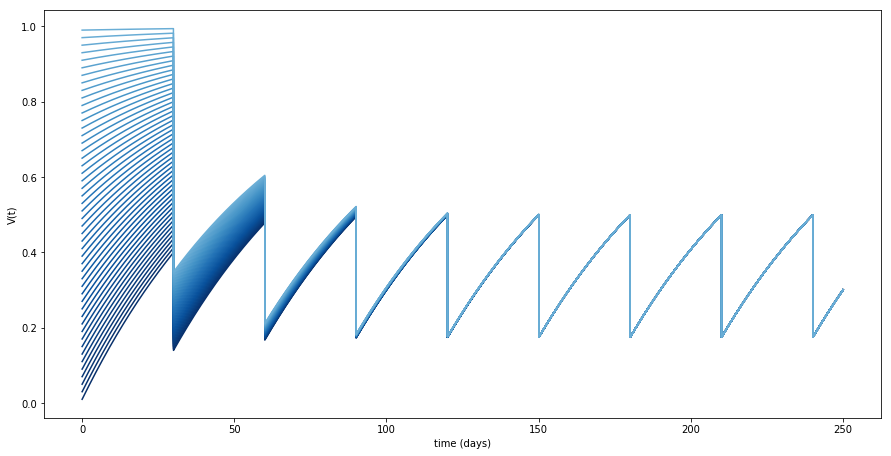

In [41]:
# To Ilustrate Periodic Veg Theorem

Y = []

for v_0 in v_0_list:
    x_0 = np.array([0.9,0.1,0.5,0,2,0.2,v_0])
    system.jump_odeint(x_0,num_days,step)
    Y.append(system.y[:,6])
    

start = 1.0
stop = 0.5
number_of_lines= len(v_0_list)
cm_subsection = linspace(start, stop, number_of_lines) 

colors = [ cm.get_cmap('Blues')(x) for x in cm_subsection ]

fig, axs = plt.subplots(1,1, figsize=(15, 7.5))

for i,y in enumerate(Y):
    #plt.plot(t,y[:,1],color = colors[i])
    axs.plot(system.time_vector, y,color = colors[i])
    axs.set_xlabel('time (days)')
    axs.set_ylabel('V(t)')

## Varying mosquito mortality

Mosquito population for varying $\mu_M$

In [44]:
x_0 = np.array([0.9,0.1,0.5,0,2,0.2,0.7])
mu_M_list = linspace(0.16, 0.23, 20)
num_days = 300
step = 0.01


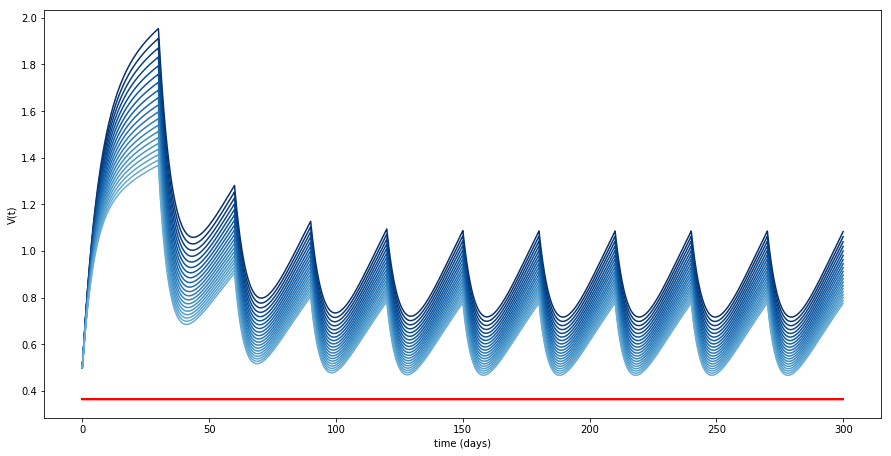

In [55]:
system = Malaria_System(params)
#system.gamma = 0


Y = []

for mu_M in mu_M_list:
    system.mu_M = mu_M
    system.jump_odeint(x_0,num_days,step)
    Y.append(system.y[:,2] + system.y[:,3])
    

start = 1.0
stop = 0.5
number_of_lines= len(mu_M_list)
cm_subsection = linspace(start, stop, number_of_lines) 

colors = [ cm.get_cmap('Blues')(x) for x in cm_subsection ]

fig, axs = plt.subplots(1,1, figsize=(15, 7.5))

for i,y in enumerate(Y):
    #plt.plot(t,y[:,1],color = colors[i])
    axs.plot(system.time_vector, y,color = colors[i])
    axs.set_xlabel('time (days)')
    axs.set_ylabel('Mosquito Population')
    
    axs.plot(system.time_vector, (1/system.R_0)*np.ones(system.time_vector.shape), color = 'red')

In [10]:
system = Malaria_System(params)
#system.gamma = 0
Y = []

for mu_M in mu_M_list:
    system.mu_M = mu_M
    system.jump_odeint(x_0,num_days,step)
    Y.append(system.y)
    

start = 1.0
stop = 0.5
number_of_lines= len(mu_M_list)
cm_subsection = linspace(start, stop, number_of_lines) 

colors = [ cm.get_cmap('Blues')(x) for x in cm_subsection ]

fig, axs = plt.subplots(1,1, figsize=(15, 7.5))

for i,y in enumerate(Y):
    #plt.plot(t,y[:,1],color = colors[i])
    axs.plot(system.time_vector, y[:,1],color = colors[i])
    axs.set_xlabel('time (days)')
    axs.set_ylabel('Proportion of Infected')

NameError: name 'params' is not defined